# 逻辑回归（Logistic Regression）

希望预测病人是否有糖尿病：

- 血糖（glucose）

- 身高体重指数（BMI）

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

path = 'Ex2Data1_sample.csv'
data = pd.read_csv(path)
data.head()


,Glucose,BMI,Outcome
0,180.0,20.0,0.0
1,92.0,38.0,0.0
2,80.0,38.0,1.0
3,70.0,18.0,0.0
4,157.0,18.0,0.0


显示数据集图像


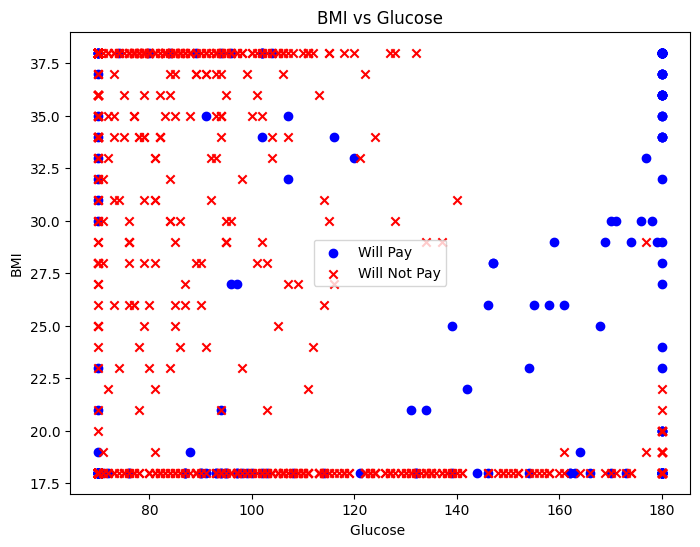

In [2]:
positive  = data[data['Outcome'].isin([1])]
negetive = data[data['Outcome']==0]

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(positive['Glucose'], positive['BMI'], marker='o', color='b', label='Will Pay')
ax.scatter(negetive['Glucose'], negetive['BMI'], marker='x', color='r', label='Will Not Pay')
ax.set_xlabel('Glucose ')
ax.set_ylabel('BMI')
ax.set_title('BMI vs Glucose')
ax.legend()
plt.show()



1. **`data['Admitted']`**  
   - 提取 DataFrame 中名为 `Admitted` 的列（通常表示目标变量，例如是否被录取、是否患病等二分类标签）。

2. **`.isin([1])` 和 `.isin([0])`**  
   - 检查 `Admitted` 列的值是否等于 `1` 或 `0`，返回一个布尔型（True/False）的 Series。  
   - 例如：若某行的 `Admitted` 值为 `1`，则 `.isin([1])` 返回 `True`，否则返回 `False`。


### **注意事项**：

2. **更简洁的写法**：  
   等价于直接使用布尔条件：
   ```python
   positive = data[data['Admitted'] == 1]
   negative = data[data['Admitted'] == 0]
   ```

3. **性能考虑**：  
   对于超大数据集，`.isin()` 可能比直接比较稍慢，但可读性更好（尤其需要匹配多个值时，如 `.isin([1, 2])`）。



### **布尔型 Series（Boolean Series）的定义**
布尔型 Series 是 Pandas 中的一种特殊数据结构，它是一个由 `True` 和 `False` 值组成的一维数组，通常由逻辑条件生成。在 Pandas 中，它常用于 **数据筛选（Data Filtering）** 和 **条件索引（Boolean Indexing）**。

---

### **关键特性**
| 特性 | 说明 |
|------|------|
| **数据类型** | `dtype=bool`（每个元素只能是 `True` 或 `False`） |
| **生成方式** | 通过逻辑运算（如 `>`, `==`, `isin()` 等）或条件判断生成 |
| **主要用途** | 1. 数据筛选（过滤行）<br>2. 条件赋值（`df.loc[boolean_series] = value`）<br>3. 结合 `&`（与）、`|`（或）、`~`（非）进行复杂条件组合 |



### **如何生成布尔型 Series？**
#### 示例 1：直接比较

In [3]:

data_exp = pd.DataFrame({"Age": [25, 30, 18, 40], "Score": [80, 90, 50, 70]})

# 生成布尔型 Series
adults = data_exp["Age"] >= 30  # 检查年龄是否 ≥18
print(adults)

0    False
1     True
2    False
3     True
Name: Age, dtype: bool


#### 示例 2：使用 `isin()`

In [4]:
# 检查 Score 是否在指定列表中
high_scores = data_exp["Score"].isin([80, 90])
print(high_scores)

0     True
1     True
2    False
3    False
Name: Score, dtype: bool


### **布尔型 Series 的用途**
#### 1. 数据筛选（布尔索引）


In [5]:
adult_data = data_exp[data_exp["Age"] > 18]
print(adult_data)


   Age  Score
0   25     80
1   30     90
3   40     70



#### 2. 多条件组合（需用 `&`、`|`、`~`）

In [6]:
filtered_data = data_exp[(data_exp["Age"] >= 18) & (data_exp["Score"] > 60)]
print(filtered_data)

   Age  Score
0   25     80
1   30     90
3   40     70



#### 3. 条件赋值

In [7]:
data_exp["Level"] = "Low"
data_exp.loc[data_exp["Score"] >= 80, "Level"] = "High"

布尔型 Series 之所以能用于数据筛选，是因为 Pandas 和 NumPy 的底层实现利用了 布尔掩码（Boolean Masking） 机制。它的核心逻辑是：
布尔掩码（Boolean Masking）原理
当使用一个布尔型 Series（True/False 或 1/0）作为索引时，Pandas/NumPy 会执行以下操作：

True（或 1）：保留该位置对应的数据行

False（或 0）：丢弃该位置对应的数据行

***通过0/1矩阵计算需要保留的元素***

# Sigmoid函数（Logistic Funciton）

### **Sigmoid函数详解**

激活函数，尤其在**逻辑回归**和**二分类问题**中扮演核心角色。它的数学表达式和特性使其非常适合将任意实数映射到`(0,1)`区间，从而解释为概率。

---
## **1. 数学定义**
Sigmoid函数的公式为：
$
\sigma(z) = \frac{1}{1 + e^{-z}}
$
其中：
- \( z \) 是输入值（可以是线性模型的输出，如 $ z = w^Tx + b $。
- \( e \) 是自然对数的底（约2.71828）。

---

Sigmoid的导数（用于梯度下降）具有简洁形式：
$
\sigma'(z) = \sigma(z) \cdot (1 - \sigma(z))
$
这一性质在反向传播中非常高效。


## **4. 优缺点**
### **优点**
- 输出可解释为概率。
- 平滑性适合梯度优化。
- 导数计算简单。

### **缺点**
- 容易导致梯度消失（当 \( |z| \) 很大时，导数接近0）。
- 输出不是零中心的（可能影响训练效率）。
- 对极端值敏感。

---

## **6. 与其他激活函数对比**
| 函数        | 输出范围   | 用途                     | 优缺点                     |
|-------------|-----------|--------------------------|----------------------------|
| **Sigmoid** | (0,1)     | 二分类概率输出           | 概率解释好，但梯度消失     |
| **Tanh**    | (-1,1)    | 隐藏层（零中心化）       | 梯度更强，但仍可能消失     |
| **ReLU**    | [0,+∞)    | 深度学习隐藏层           | 计算快，但神经元可能"死亡" |

---

## **7. 常见问题**
### **Q1: 为什么逻辑回归用Sigmoid而不是其他函数？**
- 天然适应概率输出（0~1）。
- 历史原因（源自逻辑增长模型）。
- 导数形式简单，适合最大似然估计。

### **Q2: Sigmoid的梯度消失如何解决？**
- 改用ReLU、LeakyReLU等激活函数。
- 结合批量归一化（BatchNorm）稳定输入分布。


### **sigmoid function**
$$f_{\vec{w},b}\left(\vec{x}\right)=\frac{1}{1+e^{-\left(\vec{w}\cdot\vec{x}+b\right)}}$$

注意这里的z是线性划分，如果需要其他划分，要用到其他函数，如原型使用二次函数

In [8]:
# sigmoid function
def sigmoid(z: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-z))


### **Logistic loss function**
$$L\left(f_{\vec{w},b}\left({\vec{x}}^{\left(i\right)}\right),y^{\left(i\right)}\right)=-\log{\left(f_{\vec{\omega},b}\left({\vec{x}}^{\left(i\right)}\right)\right)},if\ y^{\left(i\right)}=1$$
$$L\left(f_{\vec{w},b}\left({\vec{x}}^{\left(i\right)}\right),y^{\left(i\right)}\right)=-\log{\left({1-f}_{\vec{\omega},b}\left({\vec{x}}^{\left(i\right)}\right)\right)},if\ y^{\left(i\right)}=0$$
***simplified loss function***
$$L\left(f_{\vec{w},b}\left({\vec{x}}^{\left(i\right)}\right),y^{\left(i\right)}\right)=-y^{\left(i\right)}\log{\left(f_{\vec{w},b}\left({\vec{x}}^{\left(i\right)}\right)\right)}-\left(1-y^{\left(i\right)}\right)\log{\left(1-f_{\vec{w},b}\left({\vec{x}}^{\left(i\right)}\right)\right)}$$

### **Cost Function**
$$J\left(\vec{w},b\right)=\frac{1}{2m}\sum_{i=1}^{m}\left[L\left(f_{\vec{\omega},b}\left({\vec{x}}^{\left(i\right)}\right),y^{\left(i\right)}\right)\right]$$
代入损失函数后：
$$
J(\vec{w}, b) = -\frac{1}{m} \sum_{i=1}^m \left[ y^{(i)} \log\left(f_{\vec{w},b}\left(\vec{x}^{(i)}\right)\right) + \left(1 - y^{(i)}\right) \log\left(1 - f_{\vec{w},b}\left(\vec{x}^{(i)}\right)\right) \right]
$$

In [9]:
# Logistic Regression Cost Function 函数参数说明类型版本
def cost_function(X: np.ndarray, y: np.ndarray, w: np.ndarray, b: float) -> float:
    """
    计算逻辑回归的成本函数值。

    参数:
    X (np.ndarray): 特征矩阵，形状为 (m, n)，其中 m 是样本数，n 是特征数。
    y (np.ndarray): 标签向量，形状为 (m,)。
    w (np.ndarray): 权重向量，形状为 (n,)。
    b (float): 偏置项。

    返回:
    float: 成本函数值。
    """
    m = len(y)
    predictions = sigmoid(np.dot(X, w) + b)
    cost = -1/m * np.sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
    return cost

In [10]:
# Logistic Regression Cost Function 函数参数说明类型版本
def cost_function2(X: np.ndarray, y: np.ndarray, theta: np.ndarray) -> float:
    """
    计算逻辑回归的成本函数值。

    参数:
    X (np.ndarray): 特征矩阵，形状为 (m, n)，其中 m 是样本数，n 是特征数。
    y (np.ndarray): 标签向量，形状为 (m,)。
    theta (np.ndarray): 参数向量，形状为 (n,)。

    返回:
    float: 成本函数值。
    """
    m = len(y)
    predictions = sigmoid(np.dot(X, theta))
    cost = -1/m * np.sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
    return cost




### **Gradient Descent**
- **对权重 $w_j$ 的偏导**：
$$
\frac{\partial J(\vec{w}, b)}{\partial w_j} = \frac{1}{m} \sum_{i=1}^m \left( f_{\vec{w},b}\left(\vec{x}^{(i)}\right) - y^{(i)} \right) x_j^{(i)}
$$
- **对偏置 \(b\) 的偏导**：
$$
\frac{\partial J(\vec{w}, b)}{\partial b} = \frac{1}{m} \sum_{i=1}^m \left( f_{\vec{w},b}\left(\vec{x}^{(i)}\right) - y^{(i)} \right)
$$

在每次迭代中，更新参数：
$$
w_j := w_j - \alpha \frac{\partial J(\vec{w}, b)}{\partial w_j}
$$
$$
b := b - \alpha \frac{\partial J(\vec{w}, b)}{\partial b}
$$
其中 $\alpha$ 是学习率。

代入：
$$
\vec{w} := \vec{w} - \alpha \cdot \frac{1}{m} \sum_{i=1}^m \left( f_{\vec{w},b}\left(\vec{x}^{(i)}\right) - y^{(i)} \right) \vec{x}^{(i)}
$$
$$
b := b - \alpha \cdot \frac{1}{m} \sum_{i=1}^m \left( f_{\vec{w},b}\left(\vec{x}^{(i)}\right) - y^{(i)} \right)
$$

### 总结
- **代价函数**：
  $$
  J(\vec{w}, b) = -\frac{1}{m} \sum_{i=1}^m \left[ y^{(i)} \log\left(f_{\vec{w},b}\left(\vec{x}^{(i)}\right)\right) + \left(1 - y^{(i)}\right) \log\left(1 - f_{\vec{w},b}\left(\vec{x}^{(i)}\right)\right) \right]
  $$
- **梯度下降更新**：
  $$
  w_j := w_j - \alpha \cdot \frac{1}{m} \sum_{i=1}^m \left( f_{\vec{w},b}\left(\vec{x}^{(i)}\right) - y^{(i)} \right) x_j^{(i)}
  $$
  $$
  b := b - \alpha \cdot \frac{1}{m} \sum_{i=1}^m \left( f_{\vec{w},b}\left(\vec{x}^{(i)}\right) - y^{(i)} \right)
  $$


In [11]:
# w,b 梯度下降
def gradient_descent(X: np.ndarray, y: np.ndarray, w: np.ndarray, b: float, alpha: float, num_iterations: int) -> tuple:
    """
    使用梯度下降法优化逻辑回归的参数。

    参数:
    X (np.ndarray): 特征矩阵，形状为 (m, n)，其中 m 是样本数，n 是特征数。
    y (np.ndarray): 标签向量，形状为 (m,)。
    w (np.ndarray): 初始权重向量，形状为 (n,)。
    b (float): 初始偏置项。
    alpha (float): 学习率。
    num_iterations (int): 迭代次数。

    返回:
    tuple: 优化后的权重向量和偏置项。
    """
    m = len(y)
    
    for _ in range(num_iterations):
        predictions = sigmoid(np.dot(X, w) + b)
        error = predictions - y
        
        # 更新权重和偏置
        w -= alpha * (1/m) * np.dot(X.T, error)
        b -= alpha * (1/m) * np.sum(error)
    
    return w, b

In [12]:
# 梯度下降
def gradient_descent2(X: np.ndarray, y: np.ndarray, theta: np.ndarray, alpha: float, num_iters: int) -> tuple:
    """
    执行梯度下降算法以优化逻辑回归的参数。

    参数:
    X (np.ndarray): 特征矩阵，形状为 (m, n)。
    y (np.ndarray): 标签向量，形状为 (m,)。
    theta (np.ndarray): 初始参数向量，形状为 (n,)。
    alpha (float): 学习率。
    num_iters (int): 迭代次数。

    返回:
    tuple: 包含优化后的参数向量和每次迭代的成本值列表。
    """
    m = len(y)
    cost_history = []

    for _ in range(num_iters):
        predictions = sigmoid(np.dot(X, theta))
        errors = predictions - y
        gradient = np.dot(X.T, errors) / m
        theta -= alpha * gradient
        cost = cost_function2(X, y, theta)
        cost_history.append(cost)

    return theta, cost_history

In [13]:
cols = data.shape[1]
X = np.array(data.iloc[:, :-1])  # 特征矩阵, 取所有列，除了最后一列
y = np.array(data.iloc[:, -1])  # 标签向量, 取最后一列
w = np.zeros(X.shape[1])  # 初始化权重向量为零

'''
data.iloc[:, -1:0]会返回空结果，因为切片方向反了
data.iloc[:, -1]（取最后一列）
或data.iloc[:, -1:]（取最后一列但保持二维结构）
'''
b = 0
w, b = gradient_descent(X,y,w,b,alpha=0.0001,num_iterations=1000000)

cost_function(X, y, w, b)  # 计算成本函数值

np.float64(0.47941019264059287)

In [14]:
# 对于第二种逻辑回归成本函数，使用向量化的形式，需要对输入的X处理成一个新的参数theta
data_copy = data.copy()
data_copy['Intercept'] = 1  # 添加截距项 默认添加在最后一列

X_2 = np.array(data_copy[['Intercept', 'Glucose', 'BMI']].values)  # 特征矩阵,   重新制定了intercept列的位置
# X = X[:, [2, 0, 1]]  # 调整列顺序，将 'Intercept' 列放在第一列 另一种方法
y_2 = np.array(data_copy['Outcome'].values)  # 标签向量

theta = np.array([0.0,0.0,0.0])  # 假设的参数向量
# 或者 theta = np.zeros(X.shape[1])  # 初始化 theta 为零向量``

"""  或者
data_copy.insert(0, 'Intercept', 1)  # 在第一列添加截距项
cols = data.shape[1]  # 获取列数
X = data)copy.iloc[:, :cols-1].values  # 特征矩阵, 取所有列，除了最后一列
y = data_copy.iloc[:, cols-1].values  # 标签向量, 取最后一列 
"""
theta, cost_history = gradient_descent2(X_2, y_2, theta, alpha=0.0001, num_iters=1000000)
cost_function2(X_2, y_2, theta)  # 计算成本函数值


np.float64(0.47941019264059287)

**发现如果使用增加截距列(theta)的方法更慢**

#### ***如果计算报错则调整学习率和迭代次数***

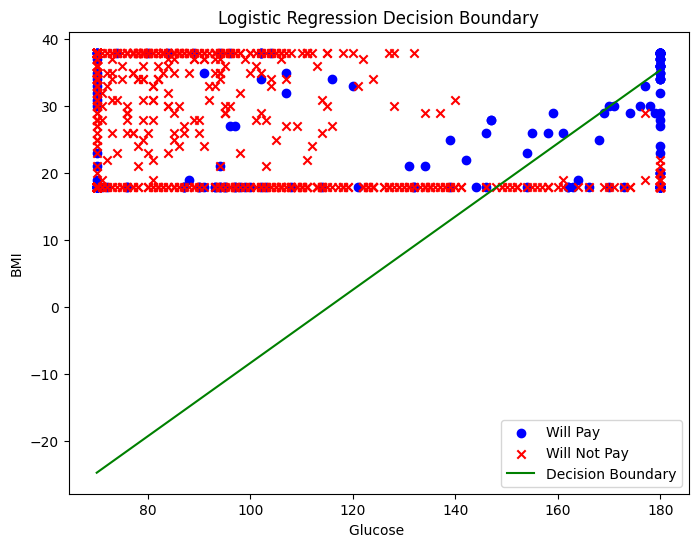

In [15]:
#绘制拟合结果
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(positive['Glucose'], positive['BMI'], marker='o', color='b', label='Will Pay')
ax.scatter(negetive['Glucose'], negetive['BMI'], marker='x', color='r', label='Will Not Pay')
x = np.linspace(data['Glucose'].min(), data['Glucose'].max(), 100)
y = -(theta[0] + theta[1] * x) / theta[2]  # 计算决策边界
ax.plot(x, y, color='g', label='Decision Boundary')
ax.set_xlabel('Glucose ')
ax.set_ylabel('BMI')
ax.set_title('Logistic Regression Decision Boundary')
ax.legend()
plt.show()



In [16]:
# 自动调整学习率并且自动收敛的梯度下降
def auto_gradient_descent(X: np.ndarray, y: np.ndarray, w: np.ndarray, b: float, initial_alpha: float = 0.01,max_iters: int = 1000, tolerance: float = 1e-20) -> tuple:
    length = len(y)
    alpha = initial_alpha
    prev_cost = float('inf')  # 初始化上一个成本为无穷大
    cost_history = []
    for _ in range(max_iters):
        predictions = sigmoid(np.dot(X, w) + b)
        error = predictions - y
        # 更新参数
        w -= alpha * np.dot(X.T, error) / length
        b -= alpha * np.sum(error) / length
        
        # 计算当前成本
        current_cost = cost_function(X, y, w, b)
        cost_history.append(current_cost)
        
        # 检查收敛条件
        if abs(prev_cost - current_cost) < tolerance:
            break
        
        # 动态调整学习率
        if current_cost > prev_cost:
            alpha *= 0.5
        else:
            alpha *= 1.05
        prev_cost = current_cost    
    return w, b, cost_history

In [17]:
cols = data.shape[1]
X = np.array(data.iloc[:, :-1])  # 特征矩阵, 取所有列，除了最后一列
y = np.array(data.iloc[:, -1])  # 标签向量, 取最后一列
w = np.zeros(X.shape[1])  # 初始化权重向量为零
b = 0

# 梯度下降
w = np.zeros(X.shape[1])  # 初始化权重向量为零
b = 0

w, b, cost_history = auto_gradient_descent(X, y, w, b, initial_alpha=0.01, max_iters=1000000)
cost_function(X, y, w, b)  # 计算成本函数值

np.float64(0.47041828026049176)

## Nom-linear decision boundary(非线性决策边界)

前面的式线性决策边界，现在讨论非线性，以圆(椭圆)形举例
$$z=w_1x_1+w_2x_2+w_3x_1^2+w_4x_2^2+w_5x_1x_2+b$$
其中 $x_1$ 、$x_2$ 是为了拟合偏移 $x_1x_2$ 是为了拟合倾斜角

当然可以对数据处理然后仅仅使用这个椭圆曲线拟合
$$z=w_1x_1^2+w_2x_2^2$$

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# 读取数据
path = "Ex2Data2.csv"
data2 = pd.read_csv(path)
data2.head()


,x,y,Outcome
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


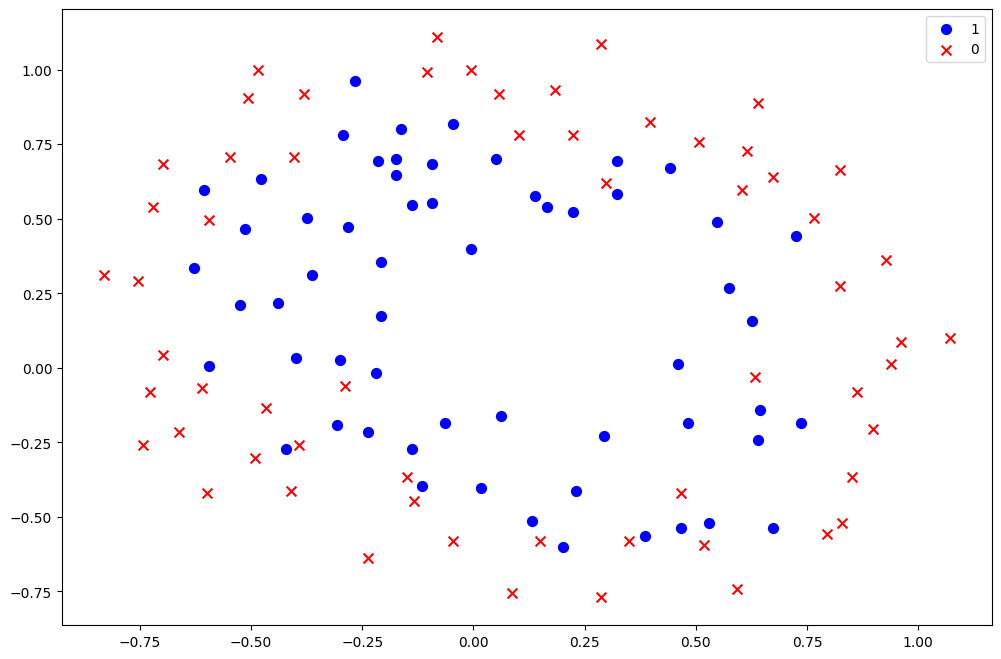

In [19]:
positive = data2[data2['Outcome'].isin([1])]
negative = data2[data2['Outcome'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['x'],positive['y'],s=50,c='b',marker='o',label='1')
ax.scatter(negative['x'],negative['y'],s=50,c='r',marker='x',label='0')
ax.legend()
plt.show()

In [20]:
# 插入高次项

# 修改列序，最后一列移到第一列
data2 = data2.iloc[:,[-1,0,1]]
degree = 5
x = data2['x']
y = data2['y']
data2.insert(1,'Intercept',1)

for i in range(2,degree+1):
    for j in range(0,i+1):
        data2['x^'+str(i-j)+' y^'+str(j)] = np.power(x,i-j)*np.power(y,j)

X = data2.iloc[:,1:]
outcome = data2.iloc[:,0]




必须使用输出数组的sigmoid定义

In [21]:
# def sigmoid(x: np.ndarray) -> np.ndarray:
#     """
#     Sigmoid function for logistic regression.
    
#     参数:
#     x (np.ndarray): 输入数组。
    
#     返回:
#     np.ndarray: Sigmoid 函数输出。
#     """
#     return 1 / (1 + np.exp(-x))

## **Cost Function Regulation** (正则化)
这是一种限制多项式高次项系数从而避免过拟合的方法(penalizing model)
$$J\left(\vec{w},b\right)=-\frac{1}{m}\sum_{i=1}^{m}\left[y^{\left(i\right)}\log{\left(f_{\vec{w},b}\left(\vec{x^{\left(i\right)}}\right)\right)}+\left(1-y^{\left(i\right)}\right)\log{\left(1-f_{\vec{w},b}\left(\vec{x^{\left(i\right)}}\right)\right)}\right]+\frac{\lambda}{2m}\sum_{j=1}^{n}w_j^2$$
其中，m是样本数，n是项数，j可以调整

In [22]:
def Regularized_CostFunction(theta: np.ndarray, X: np.ndarray, outcome: np.ndarray, Lambda: float) -> float:
    """
    Compute the regularized logistic regression cost function.
    
    Parameters:
    theta (np.ndarray): Parameters vector (n x 1)
    X (np.ndarray): Feature matrix (m x n)
    outcome (np.ndarray): Target vector (m x 1)
    Lambda (float): Regularization parameter
    
    Returns:
    float: Computed cost value
    """
    # Convert all inputs to numpy arrays to avoid pandas behavior
    theta = np.array(theta).reshape(-1, 1)
    X = np.array(X)
    outcome = np.array(outcome).reshape(-1, 1)
    
    m = outcome.shape[0]  # Number of training examples
    z = X @ theta
    h = sigmoid(z)
    
    # Compute cost terms
    cost = - np.sum(outcome.T @ np.log(h) + (1 - outcome).T @ np.log(1 - h)) / m
    reg = (Lambda / (2 * m)) * np.sum(theta[1:]**2)  # Skip theta[0] for regularization
    
    # Return as scalar float
    return float(cost + reg)

theta = np.zeros(X.shape[1])  # 初始化 theta 为零向量
Regularized_CostFunction(theta, X, outcome, Lambda=1.0)  # 计算正则化成本函数值
    

0.6931471805599454

$$\theta_0:=\theta_0-\alpha\frac{1}{m}\sum_{i=1}^{m}{\left[f_{\vec{w},b}\left({\vec{x}}^{\left(i\right)}\right)-y^{\left(i\right)}\right]x_0^{\left(i\right)}}$$
$$\theta_j:=\theta_j-\alpha\frac{1}{m}\sum_{i=1}^{m}{f_{\vec{w},b}\left[\left({\vec{x}}^{\left(i\right)}\right)-y^{\left(i\right)}\right]x_j^{\left(i\right)}}+\alpha\frac{\lambda}{m}\theta_j$$

In [23]:
# 基于上面公式的自动控制学习率并收敛线性回归
def Regularized_gradient_descent(theta: np.ndarray, X: np.ndarray, outcome: np.ndarray, 
                               Lambda: float, initial_alpha: float, 
                               max_iter: int, tolerance: float) -> list:
    # 转换输入为NumPy数组（处理Pandas Series/DataFrame情况）
    X = np.array(X) if not isinstance(X, np.ndarray) else X
    outcome = np.array(outcome).reshape(-1, 1)  # 确保是列向量
    theta = theta.reshape(-1, 1)  # 确保theta是列向量
    m, n = X.shape  # 样本数, 特征数
    
    
    cost_history = []
    pre_cost = float('inf')
    
    for _ in range(max_iter):
        # 向量化计算
        
        predictions = sigmoid(X @ theta)
        error = predictions - outcome # m*1
        
        # 计算梯度
        gradient = X * error  # 广播乘法，逐元素相乘X每一行乘上error的每一行
        gradient = np.sum(gradient, axis=0).reshape(-1, 1) / m # axis=0: 沿着第0轴（行方向）求和，结果是一个长度为 n 的 1D 数组（每个特征对应的梯度分量求和）
        # 结果reshape为 (n, 1) 列向量
        
        # 更新参数（带正则化）
        theta[0] -= initial_alpha * gradient[0]  # 不带正则化的第一个参数
        for j in range(1, n):
            theta[j] = theta[j] * (1 - initial_alpha * Lambda/m) - (initial_alpha) * gradient[j]
        
        # 计算成本
        current_cost = Regularized_CostFunction(theta, X, outcome, Lambda)
        cost_history.append(float(current_cost))
        
        # 收敛检查
        if abs(pre_cost - current_cost) < tolerance:
            break
            
        # 自适应学习率
        if pre_cost > current_cost:
            initial_alpha *= 1.05
        else:
            initial_alpha *= 0.5
            
        pre_cost = current_cost
    
    return cost_history



如果 error 是向量（形状 (m,)），X 是矩阵（形状 (m, n)）：

np.multiply(error, X) 会先将 error 广播（自动扩展）成 (m, n) 的形状，使其与 X 的每一列相乘(然后进行族元素逐渐元素乘法)

In [24]:
Lambda = 1.0
initial_alpha = 0.01
theta = np.zeros(X.shape[1])  # 初始化 theta 为零向量

cost_history = Regularized_gradient_descent(theta, X, outcome, Lambda, initial_alpha, max_iter=1000000, tolerance=1e-20)


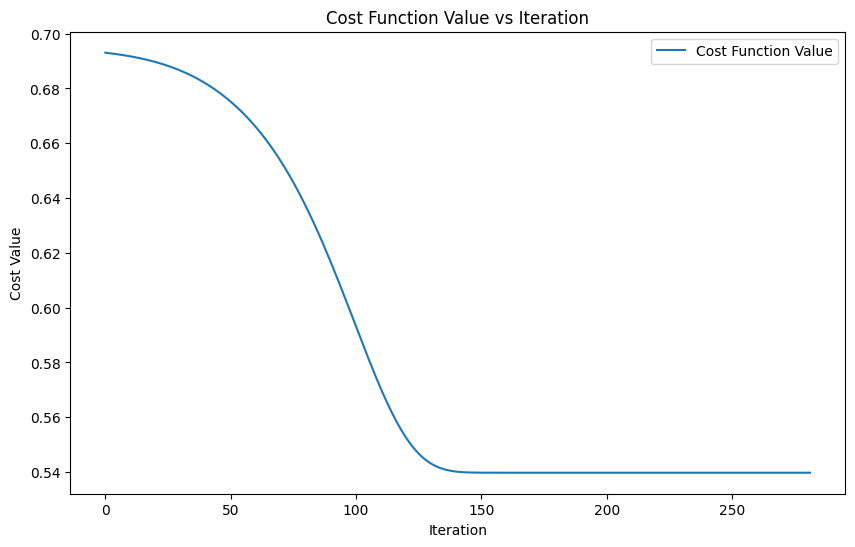

In [25]:
# 绘制成本函数值随迭代次数的变化
plt.figure(figsize=(10, 6))
plt.plot(cost_history, label='Cost Function Value')
plt.xlabel('Iteration')
plt.ylabel('Cost Value')
plt.title('Cost Function Value vs Iteration')
plt.legend()
plt.show()

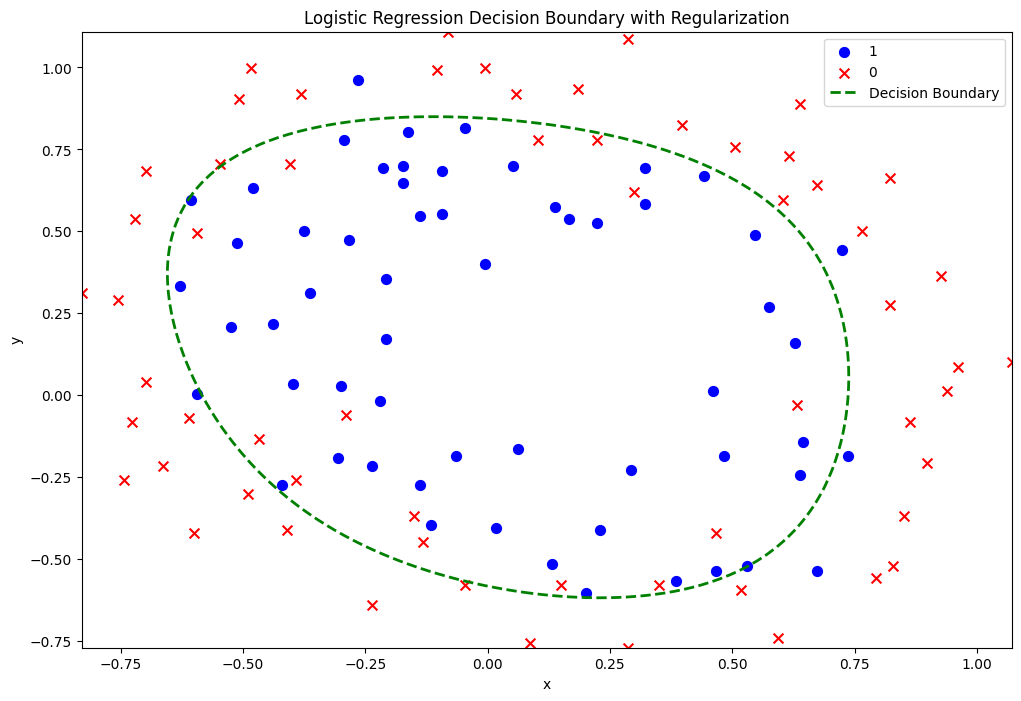

In [26]:
# 绘制拟合结果
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(positive['x'], positive['y'], s=50, c='b', marker='o', label='1')
ax.scatter(negative['x'], negative['y'], s=50, c='r', marker='x', label='0')
x = np.linspace(data2['x'].min(), data2['x'].max(), 100)
y = np.linspace(data2['y'].min(), data2['y'].max(), 100)
X_grid, Y_grid = np.meshgrid(x, y)
Z = np.zeros(X_grid.shape)

# 把二维图像所有点都带入到sigmoid函数中计算，然后绘制‘等高线’
for i in range(X_grid.shape[0]):
    for j in range(X_grid.shape[1]):
        features = np.array([1, X_grid[i, j], Y_grid[i, j]])
        for k in range(2, degree + 1):
            for l in range(0, k + 1):
                features = np.append(features, (X_grid[i, j] ** (k - l)) * (Y_grid[i, j] ** l))
        Z[i, j] = sigmoid(np.dot(features, theta))

# 绘制决策边界
contour = ax.contour(X_grid, Y_grid, Z, levels=[0.5], colors='g', linewidths=2, linestyles='dashed')

# 创建一个代理对象用于图例
proxy = plt.Line2D([], [], color='green', linestyle='dashed', linewidth=2, label='Decision Boundary')

# 添加图例（同时包含散点和决策边界）
ax.legend(handles=[*ax.get_legend_handles_labels()[0], proxy])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Logistic Regression Decision Boundary with Regularization')

plt.show()


d:\Python\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


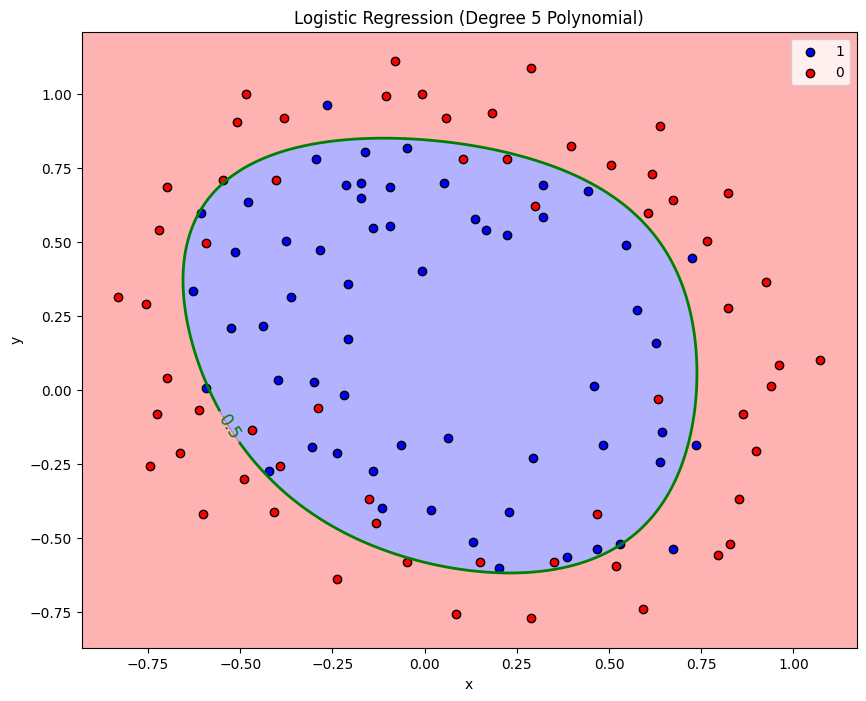

In [27]:
# 使用高级Python库如Scikit-learn进行逻辑回归
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# 1. 创建并训练模型
degree = 5
model = make_pipeline(
    PolynomialFeatures(degree),
    LogisticRegression(C=1.0, solver='lbfgs', max_iter=10000)
)
model.fit(data2[['x', 'y']], data2['Outcome'])

# 2. 准备绘图数据
x_min, x_max = data2['x'].min() - 0.1, data2['x'].max() + 0.1
y_min, y_max = data2['y'].min() - 0.1, data2['y'].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

# 3. 预测网格点的类别概率
Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

# 4. 绘制结果
plt.figure(figsize=(10, 8))
# 绘制决策边界和填充区域
plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.3, colors=['red', 'blue'])
contour = plt.contour(xx, yy, Z, levels=[0.5], colors='green', linewidths=2)
# 绘制数据点
plt.scatter(data2[data2['Outcome']==1]['x'], 
            data2[data2['Outcome']==1]['y'],
            c='blue', edgecolors='k', label='1')
plt.scatter(data2[data2['Outcome']==0]['x'],
            data2[data2['Outcome']==0]['y'],
            c='red', edgecolors='k', label='0')
# 添加图例和标签
plt.clabel(contour, inline=True, fontsize=12)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Logistic Regression (Degree {degree} Polynomial)')
plt.legend()
plt.show()